In [1]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

#import torch_xla
#import torch_xla.core.xla_model as xm

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb

random.seed(2020)
np.random.seed(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X

In [3]:
def make_offdf(train_df, original_test_df, feature, params_list, _type):
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    
    y_1 = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
    y_2 = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
    y_3 = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
    y_4 = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
    
    off_df = []
    test_df = original_test_df.copy()
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']=0
    
    for trn, val in k.split(train_df, train_df.jobflag):
        train_X, val_X = train_df.iloc[trn,:][feature], train_df.iloc[val,:][feature]
        tmp_off_df = train_df.iloc[val,:]
        c=1
        for y, param in zip([y_1, y_2, y_3, y_4], params_list):
            tmp_off_df[f'lgb_preds_{c}_{_type}']=0
            for _ in range(5):
                train_y, val_y = y.iloc[trn], y.iloc[val]
                train_set= lgb.Dataset(train_X,  train_y)
                val_set = lgb.Dataset(val_X,  val_y)   

                model = lgb.train(
                    train_set=train_set, valid_sets=[train_set, val_set], params=param, num_boost_round=3000, 
                    early_stopping_rounds=200, verbose_eval=500
                )
                tmp_off_df[f'lgb_preds_{c}_{_type}'] += model.predict(val_X)/5
                param['random_state']+=1
                
                test_df[f'lgb_preds_{c}_{_type}'] += model.predict(test_df[feature])/5
                
            c+=1
        
        off_df.append(tmp_off_df)
    
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']/=5
    
    off_df = pd.concat(off_df, axis=0)
    off_df.sort_values('text_id', inplace=True)
    return off_df.reset_index(drop=True), test_df

In [4]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = self.X[index]
        x = torch.FloatTensor(x)
        
        
        if self.y!=None:
            return {
                'input': x,
                'label': torch.FloatTensor(self.y[index])
            }
        else:
            return {
                'input': x
            }

In [5]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / np.sqrt(label_to_count[self._get_label(dataset, idx)])
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        """if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError"""
        return dataset.y[idx][0]
        
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [6]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_1 = pred[target<1.5][:,0]
        loss_1 = torch.mean((pred_1-1)**2)
        
        pred_2 = pred[(target>1.5)&(target<2.5)][:,1]
        loss_2 = torch.mean((pred_2-1)**2)
        
        pred_3 = pred[(target>2.5)&(target<3.5)][:,2]
        loss_3 = torch.mean((pred_3-1)**2)

        pred_4 = pred[target>3.5][:,3]
        loss_4 = torch.mean((pred_4-1)**2)
        
        loss = loss_1 + loss_2 + loss_3 + loss_4
        
        return loss

In [7]:
class MLPClass(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_layers[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[1], output_size)
        )
        
            
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        #x= self.sigmoid(x)
        x= self.softmax(x)
        return x

In [8]:
class Model_Trainer:
    def __init__(self, output_size, feature, hidden_layers, lr=6e-4, weight_decay=0.0005):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass(len(feature), output_size, hidden_layers).to(self.device)
        self.criterion = CustomLoss()
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = CosineAnnealingLR(optimizer=self.optimizer, T_max=10)
        self.output_size = output_size
        self.hidden_layers = hidden_layers

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    
    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label'].squeeze(1)
            if len(np.unique(label))!=4:
                continue
            label = label.to(self.device)
            x = self.model(x)   
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            
        return avg_loss

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device).squeeze(1)
            x = self.model(x)
            loss = self.criterion(x, label)
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, x.detach().cpu().numpy()

    def predict(self, data_loader):
        self.model.eval()
        for data in data_loader:
            x = data['input'].to(self.device)
            x = self.model(x)
        return x.detach().cpu().numpy()

In [9]:
class Train_Predict:
    
    def __init__(self, train_df, test_df, feature, hidden_layers, lr=6e-4, weight_decay=0.0005):
        self.train_df = train_df
        self.test_df = test_df
        self.feature = feature
        self.hidden_layers = hidden_layers
        self.lr=lr
        self.weight_decay = weight_decay
    
    def init_model(self):
        self.model_trainer = Model_Trainer(output_size=4, feature=self.feature, hidden_layers=self.hidden_layers,
                                           lr=self.lr, weight_decay=self.weight_decay)
        
    def make_off_df(self, epoch_num=40, k=None):
        if k==None:
            k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
        trn_cv_loss = []
        val_cv_loss = []
        off_df=[]

        for trn, val in tqdm( k.split(self.train_df, self.train_df.jobflag) ):
            trn_df = self.train_df.iloc[
                trn,:
            ]
            val_df = self.train_df.iloc[
                val,:
            ]

            trn_X, trn_y = trn_df[self.feature].values.tolist(),trn_df[['jobflag']].values.tolist() 
            val_X, val_y = val_df[self.feature].values.tolist(),val_df[['jobflag']].values.tolist() 


            trn_data_set = CreateDataset(trn_X, trn_y)
            val_data_set = CreateDataset(val_X, val_y)
            trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=512, sampler=ImbalancedDatasetSampler(trn_data_set))
            val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))



            trn_loss_list=[]
            val_loss_list=[]

            #model_trainer = Model_Trainer(4, feature)
            self.init_model()
            
            for e in range(epoch_num):
                trn_loss_avg = self.model_trainer.train(trn_dataloader)
                val_loss_avg, p = self.model_trainer.eval(val_dataloader)
                for mm in range(4):
                    val_df[f'p_{mm+1}_{e}'] = p[:,mm]
                val_df[f'p_{e}'] = np.argmax(p, axis=1)+1

                trn_loss_list.append(trn_loss_avg)
                val_loss_list.append(val_loss_avg)

            trn_cv_loss.append(trn_loss_list)
            val_cv_loss.append(val_loss_list)
            off_df.append(val_df)

        off_df = pd.concat(off_df, axis=0)
        off_df.sort_values('text_id', inplace=True)
        off_df.reset_index(drop=True, inplace=True)
        return off_df, trn_cv_loss, val_cv_loss
    
    def predict_test_df(self, epoch_num=40):

        X, y = self.train_df[self.feature].values.tolist(), self.train_df[['jobflag']].values.tolist()
        trn_data_set = CreateDataset(X, y)
        trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=512, sampler=ImbalancedDatasetSampler(trn_data_set))

        val_X, val_y = self.test_df[self.feature].values.tolist(), None
        val_data_set = CreateDataset(val_X, val_y)
        val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))

        trn_loss_list=[]
        
        test_df = self.test_df.copy()
        
        self.init_model()

        for e in tqdm(range(epoch_num)):
            trn_loss_avg = self.model_trainer.train(trn_dataloader)
            p = self.model_trainer.predict(val_dataloader)
            for mm in range(4):
                test_df[f'p_{mm+1}_{e}'] = p[:,mm]
            test_df[f'p_{e}'] = np.argmax(p, axis=1)+1

            trn_loss_list.append(trn_loss_avg)

        return test_df, trn_loss_list

In [10]:
def make_tfidf_df(o_df, col='description'):
    df = o_df.copy()
    id_cols = ['jobflag','text_id']
    preprocessing = Preprocessing()
    for lan_col in ['description','translate_de', 'translate_es', 'translate_fr', 'translate_ja']:
        df[lan_col] = df[lan_col].apply(lambda x: preprocessing.change_text(x))
        
    X = preprocessing.vectorize_tfidf(df[col])
    X = pd.concat([df[id_cols], X], axis=1)
    train_df = X[X.jobflag.notnull()].reset_index(drop=True)
    test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)
    mlp_feature = train_df.drop(columns=id_cols).columns.tolist()
    return train_df, test_df, mlp_feature

In [11]:
train_df = pd.read_csv('../train_translated.csv')
test_df = pd.read_csv('../test_translated.csv')
df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
df['text_id'] = df['id']
del df['id']

In [13]:
def make_step1_off(df):
    result_dic={}
    off_df_dic={}
    test_df_dic={}
    
    epoch_num= 40
    
    for language in ['description','translate_de', 'translate_es', 'translate_fr', 'translate_ja']:
        train_df, test_df, mlp_feature = make_tfidf_df(df, language)
        
        train_predict = Train_Predict(train_df, test_df, mlp_feature, hidden_layers=[300, 100], lr=0.0006, weight_decay=0.0005)
        
        off_df_mlp, trn_cv_loss, val_cv_loss = train_predict.make_off_df(epoch_num=epoch_num)
        test_df_mlp, trn_loss_list = train_predict.predict_test_df(epoch_num=epoch_num)
        
        scores=[]
        for i in range(epoch_num):   
            p = off_df_mlp[f'p_{i}']
            label = off_df_mlp['jobflag']
            score = metrics.f1_score(label, p, average='macro')
            scores.append(score)
        data = pd.DataFrame()
        data['score'] = scores
        data['test_trn_loss'] = trn_loss_list
        for i in range(len(trn_cv_loss)):
            data[f'train_trn_loss_k{i+1}'] = trn_cv_loss[i]
            data[f'train_val_loss_k{i+1}'] = val_cv_loss[i]
        
        result_dic[language]=data
        off_df_dic[language]=off_df_mlp
        test_df_dic[language]=test_df_mlp
        
    return off_df_dic, test_df_dic, result_dic

In [14]:
def make_step2_off(off_df2, test_df2, mlp_feature2):
    result_dic={}
    off_df_dic={}
    test_df_dic={}
    
    epoch_num= 60
    
    train_predict = Train_Predict(off_df2, test_df2, mlp_feature2, hidden_layers=[200, 100], lr=0.0001, weight_decay=0.0000001)
    off_df_mlp, trn_cv_loss, val_cv_loss = train_predict.make_off_df(epoch_num=epoch_num)
    test_df_mlp, trn_loss_list = train_predict.predict_test_df(epoch_num=epoch_num)
    
    scores=[]
    for i in range(epoch_num):   
        p = off_df_mlp[f'p_{i}']
        label = off_df_mlp['jobflag']
        score = metrics.f1_score(label, p, average='macro')
        scores.append(score)
    result_data = pd.DataFrame()
    result_data['score'] = scores
    result_data['test_trn_loss'] = trn_loss_list
    for i in range(len(trn_cv_loss)):
        result_data[f'train_trn_loss_k{i+1}'] = trn_cv_loss[i]
        result_data[f'train_val_loss_k{i+1}'] = val_cv_loss[i]

    return off_df_mlp, test_df_mlp, result_data

In [15]:
%%time
off_df_dic, test_df_dic, result_dic = make_step1_off(df)


Wall time: 4min 21s


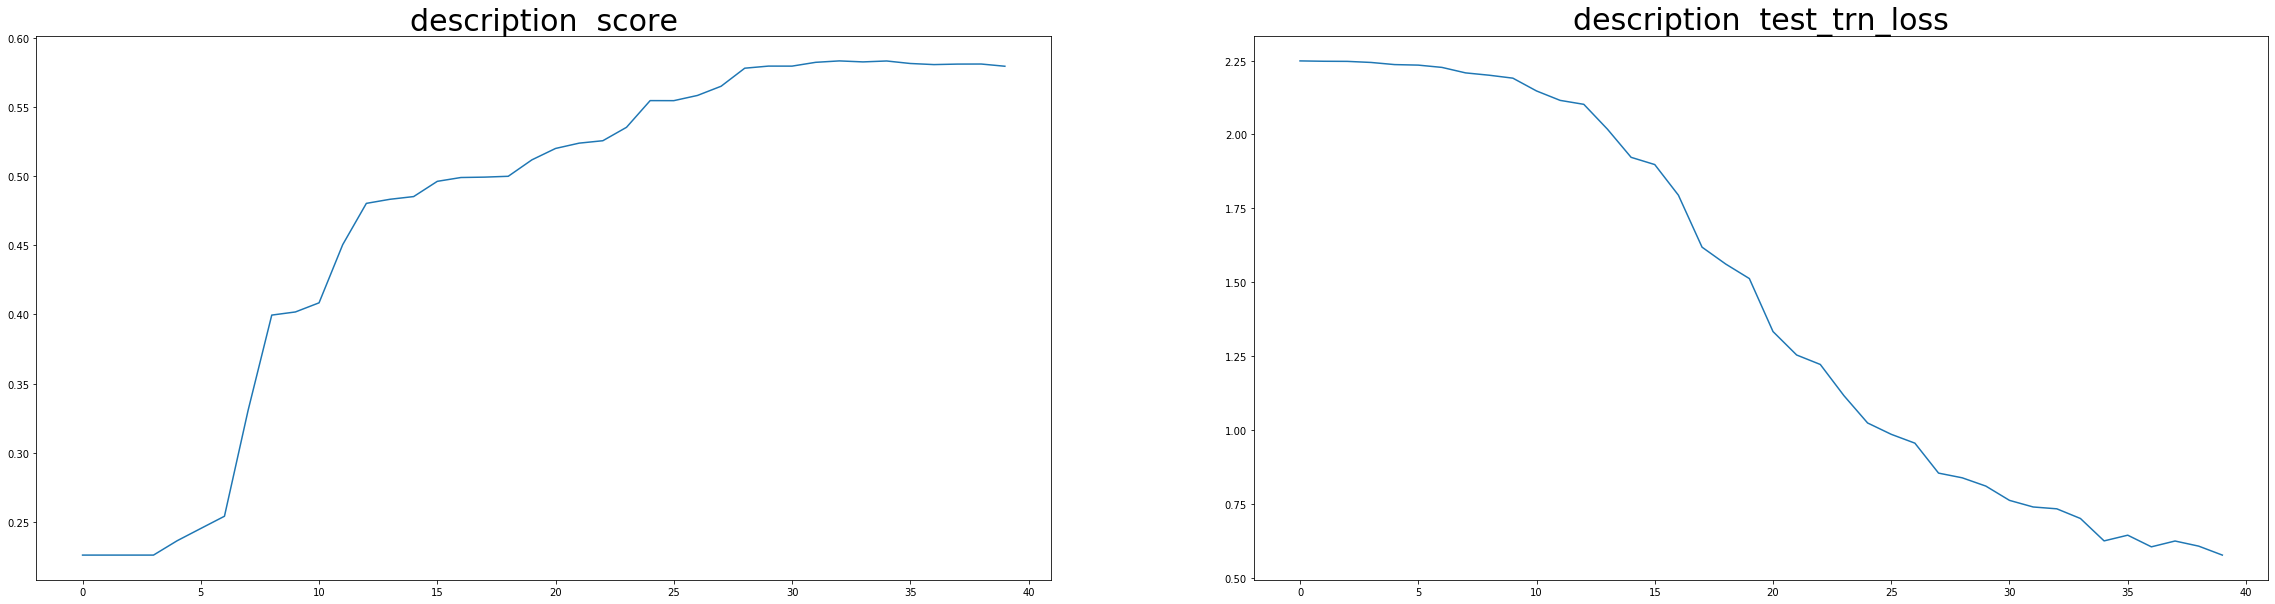

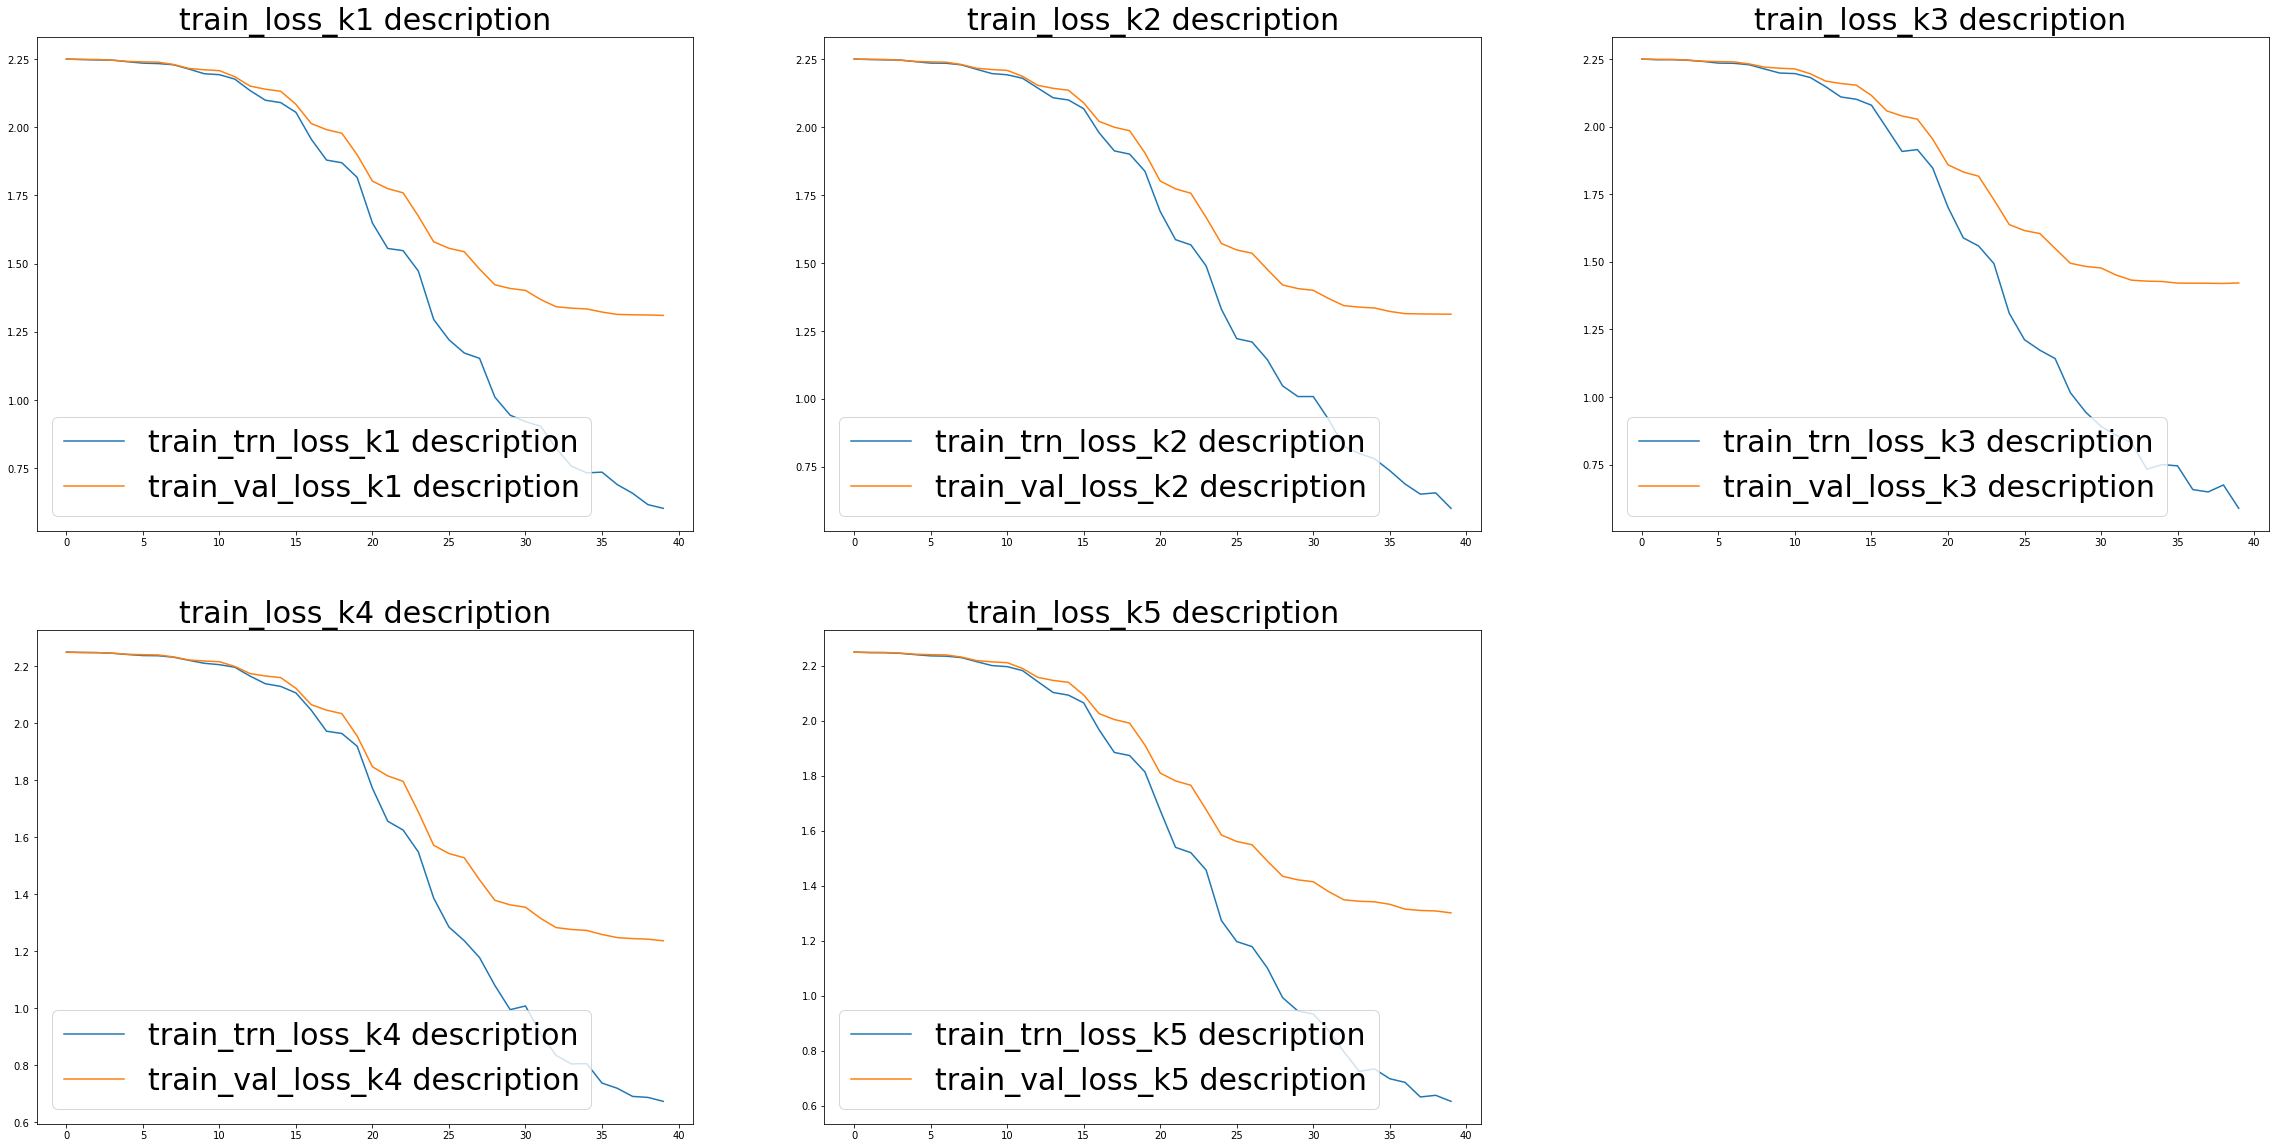

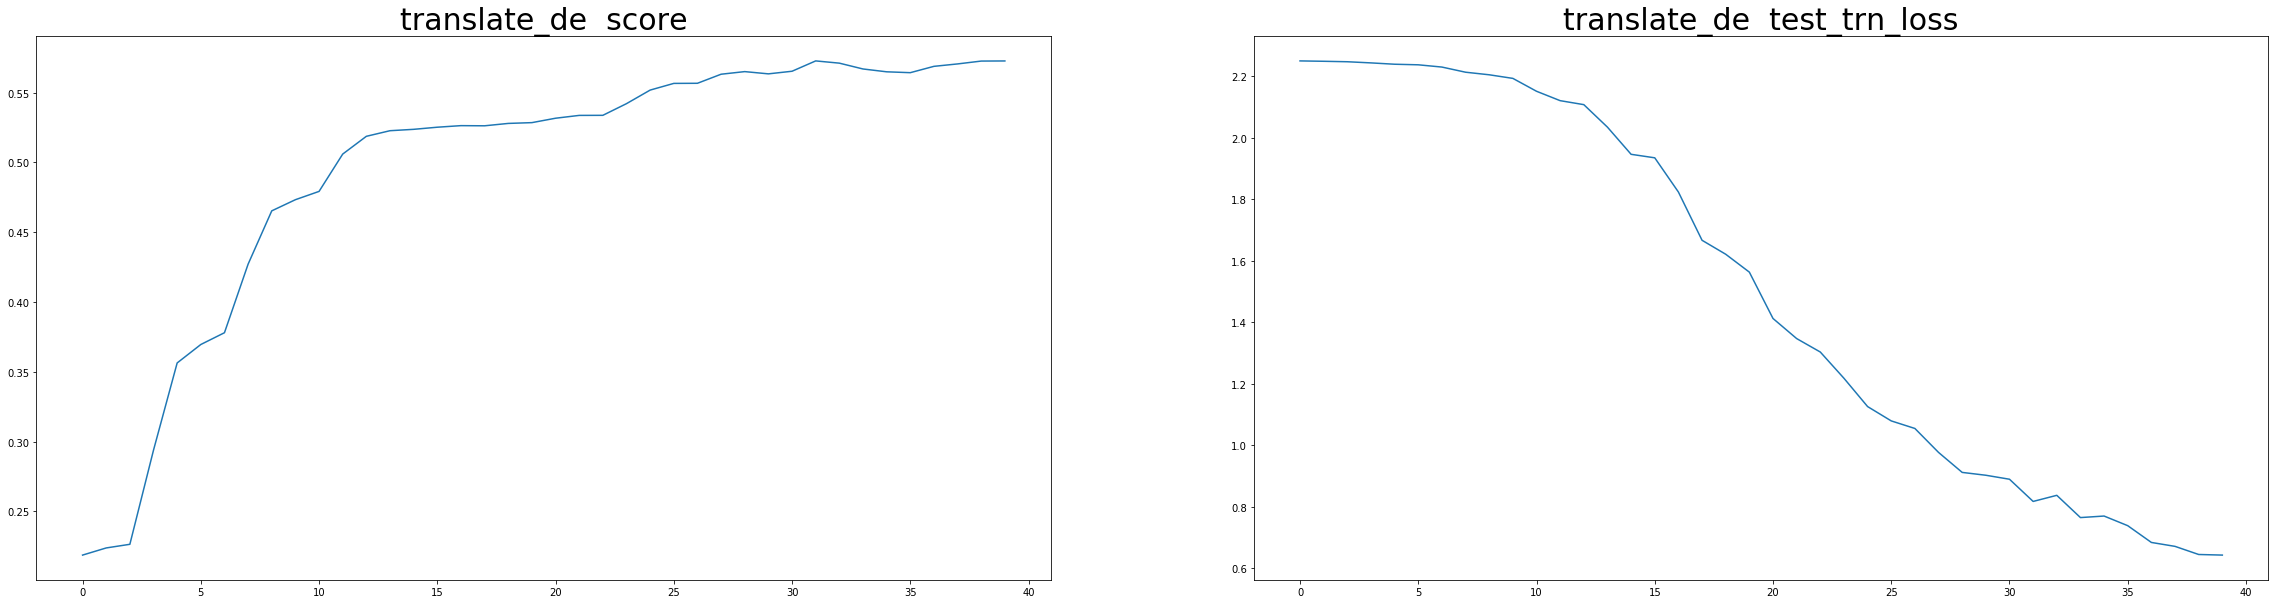

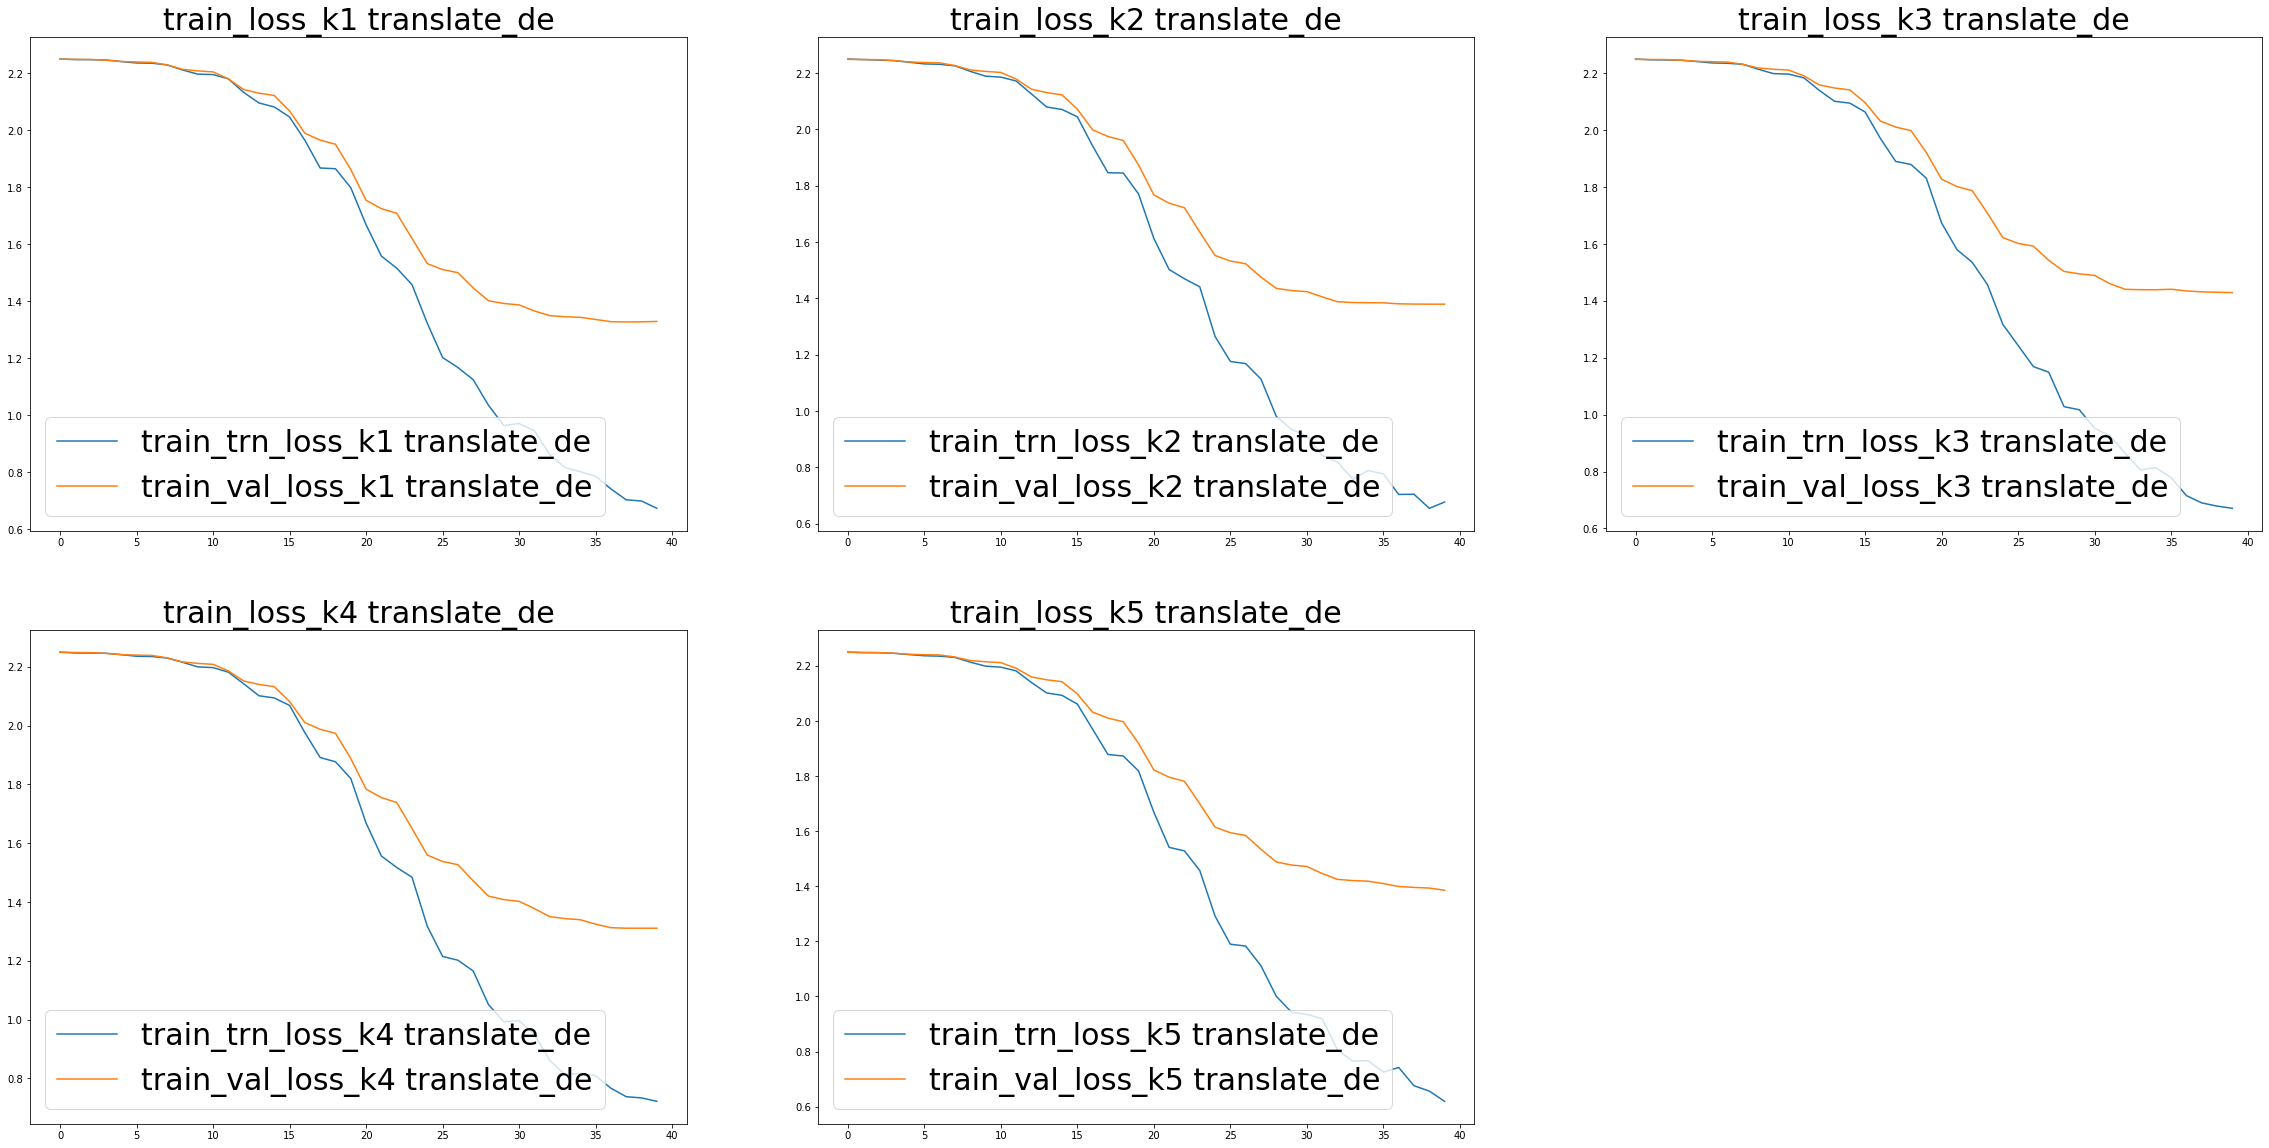

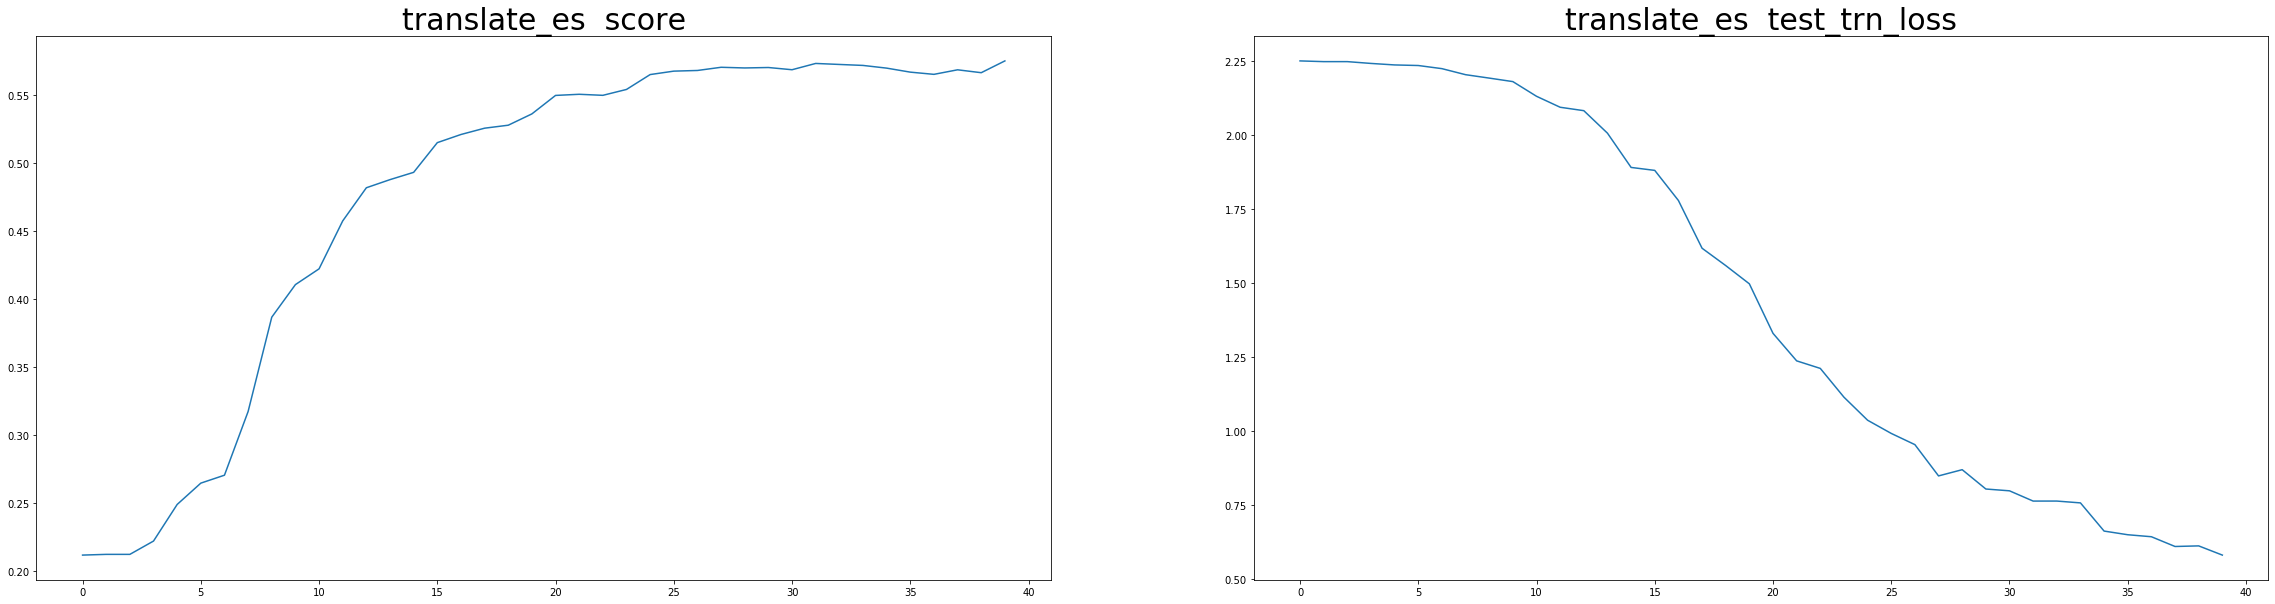

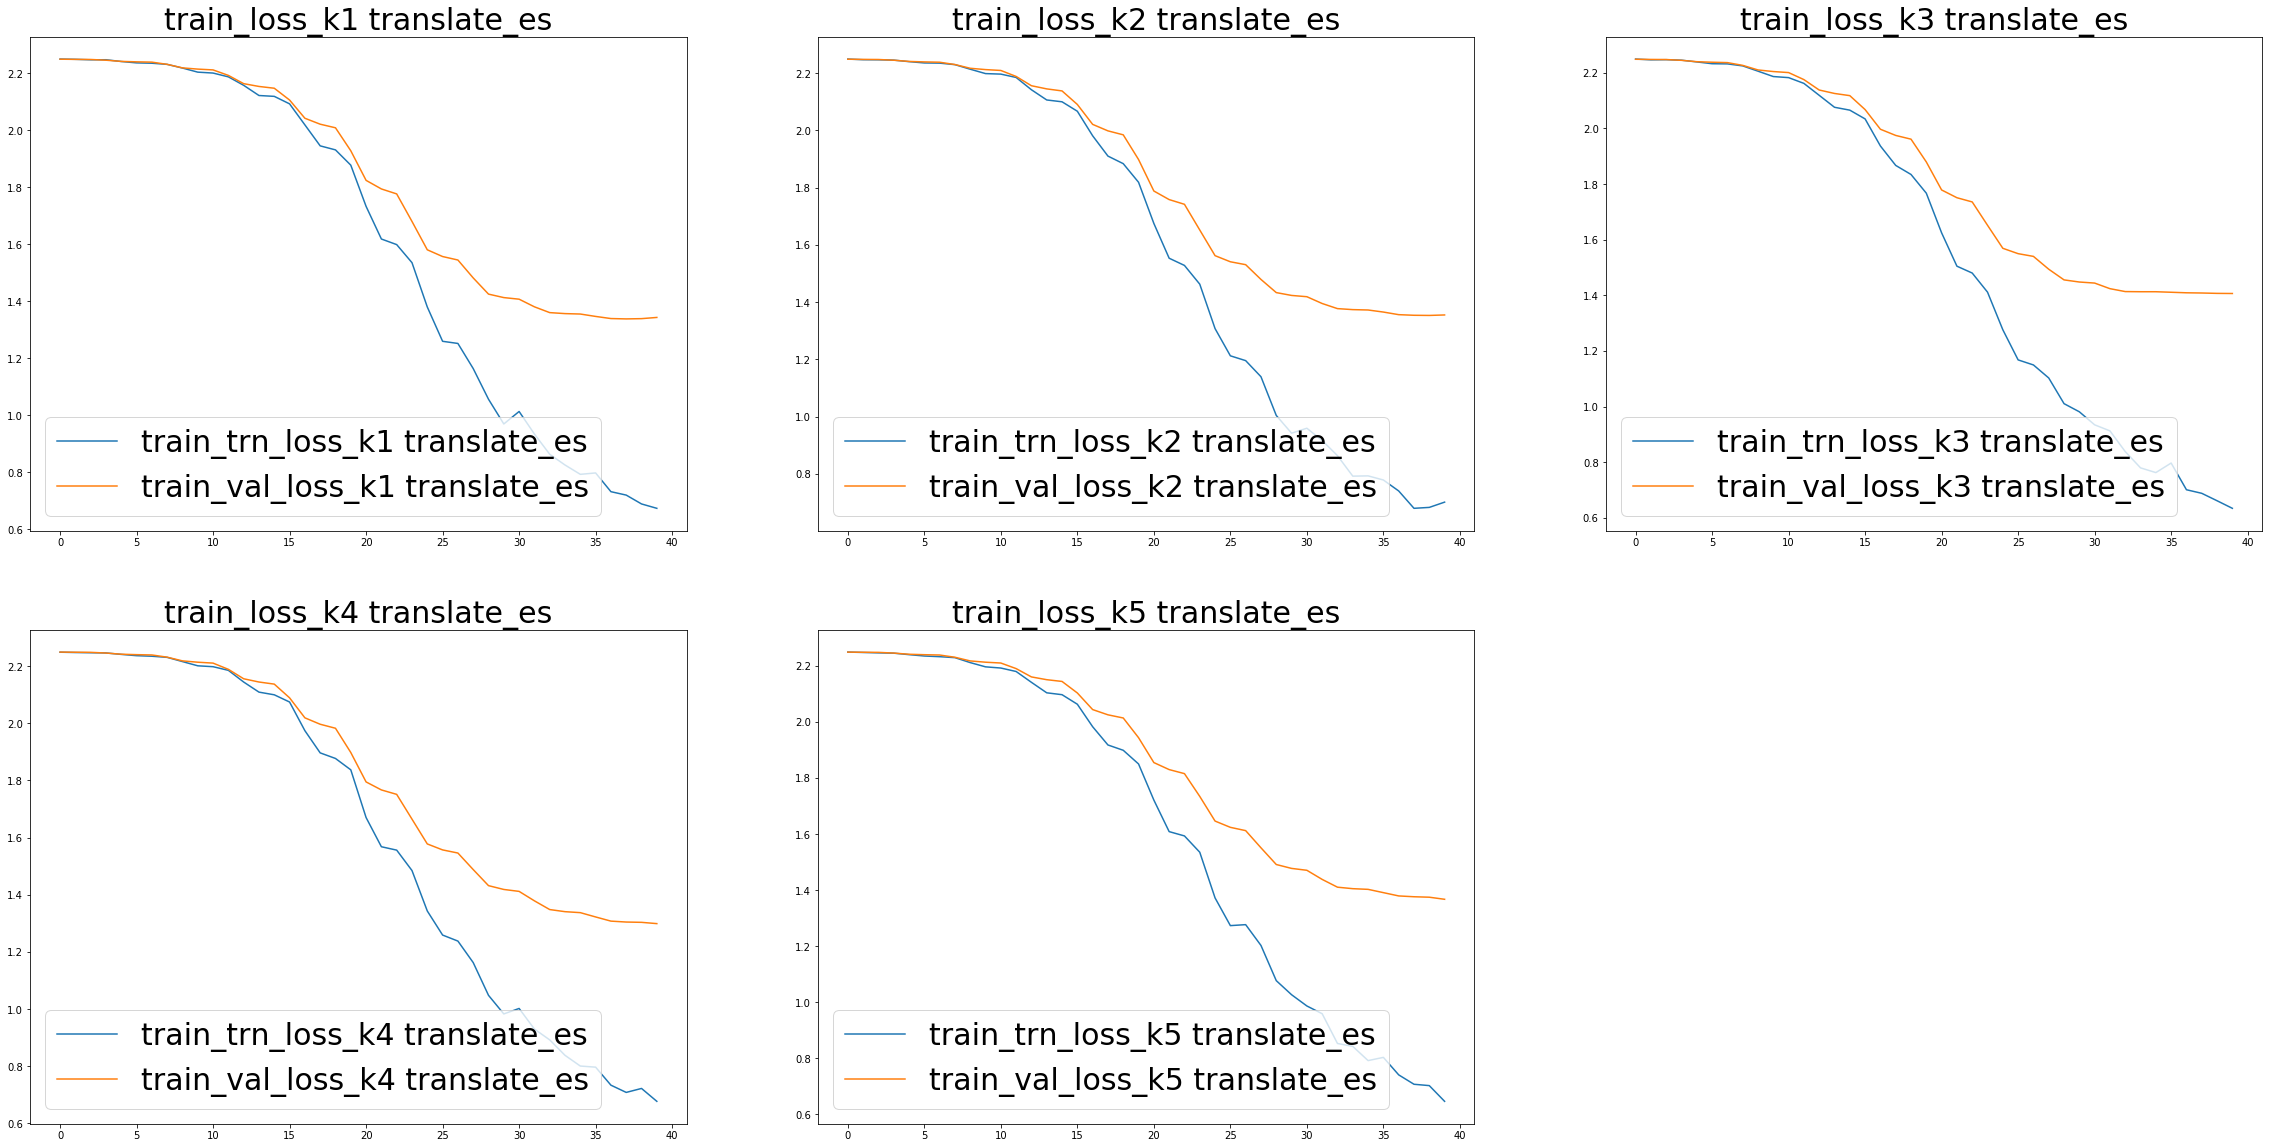

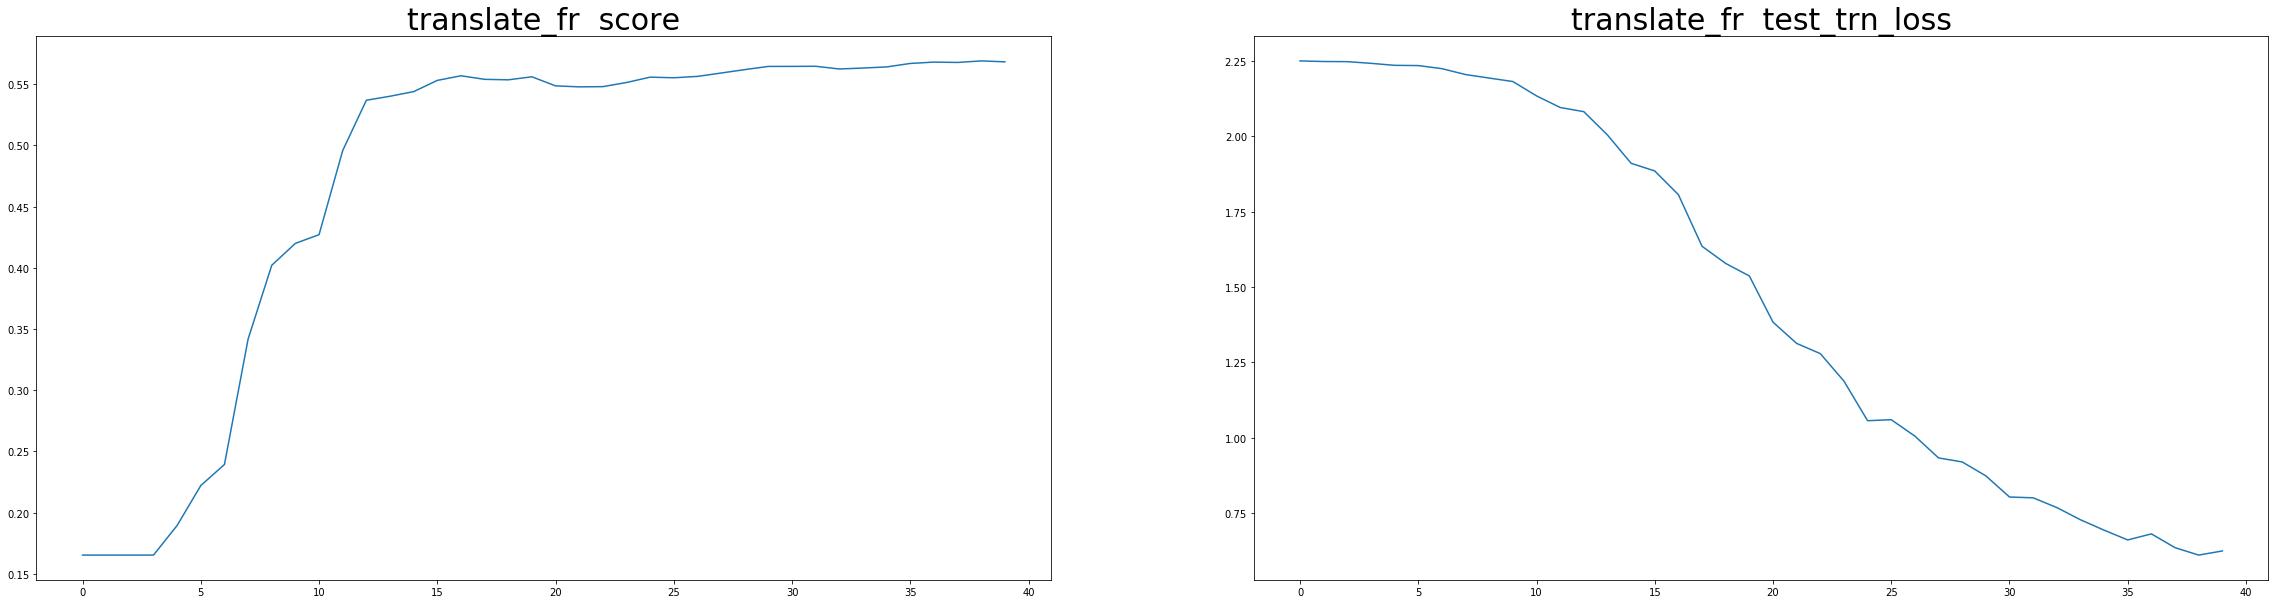

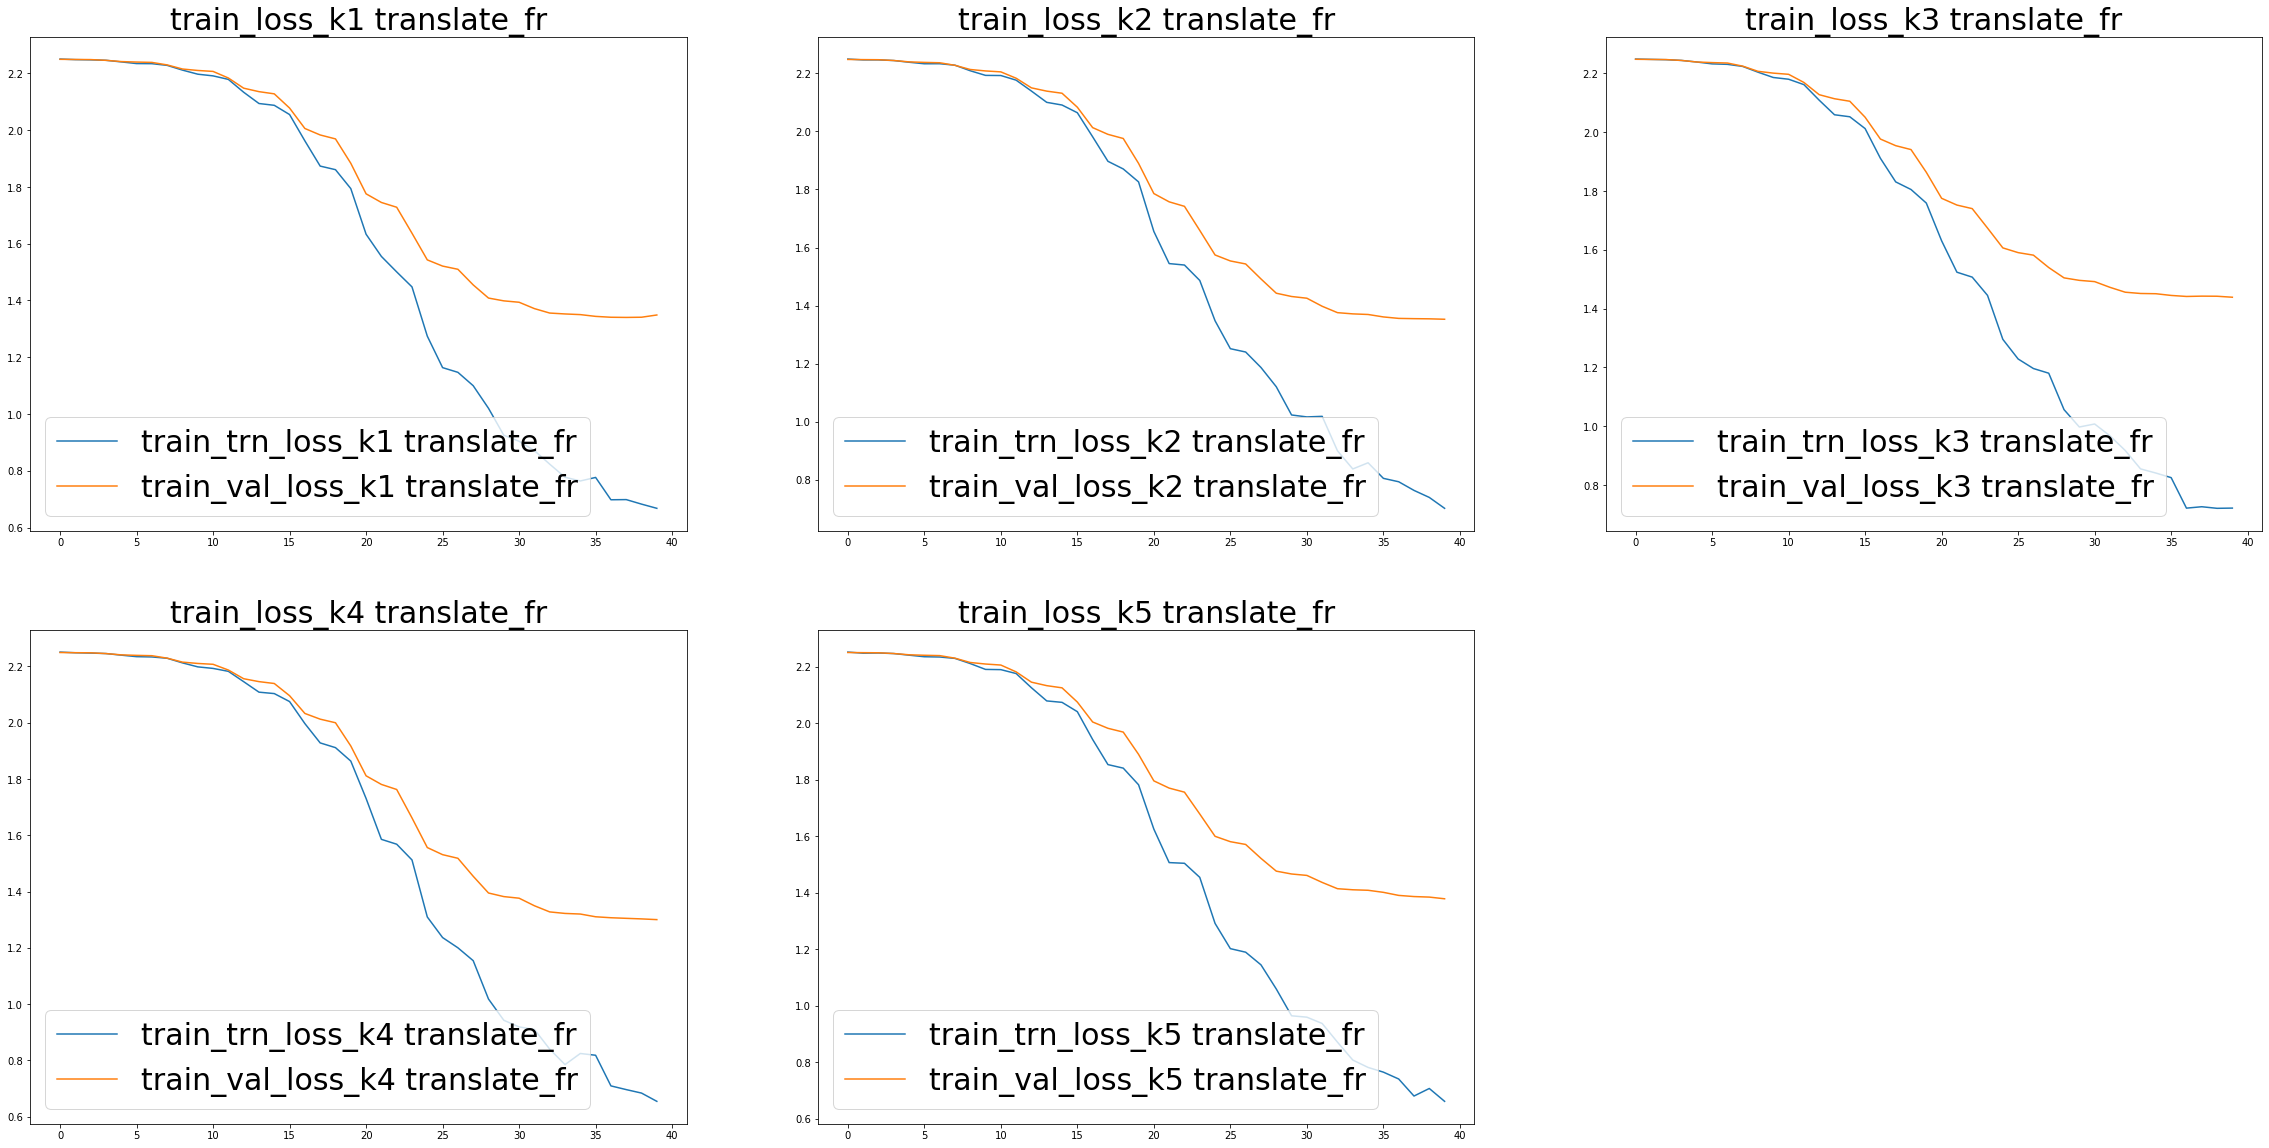

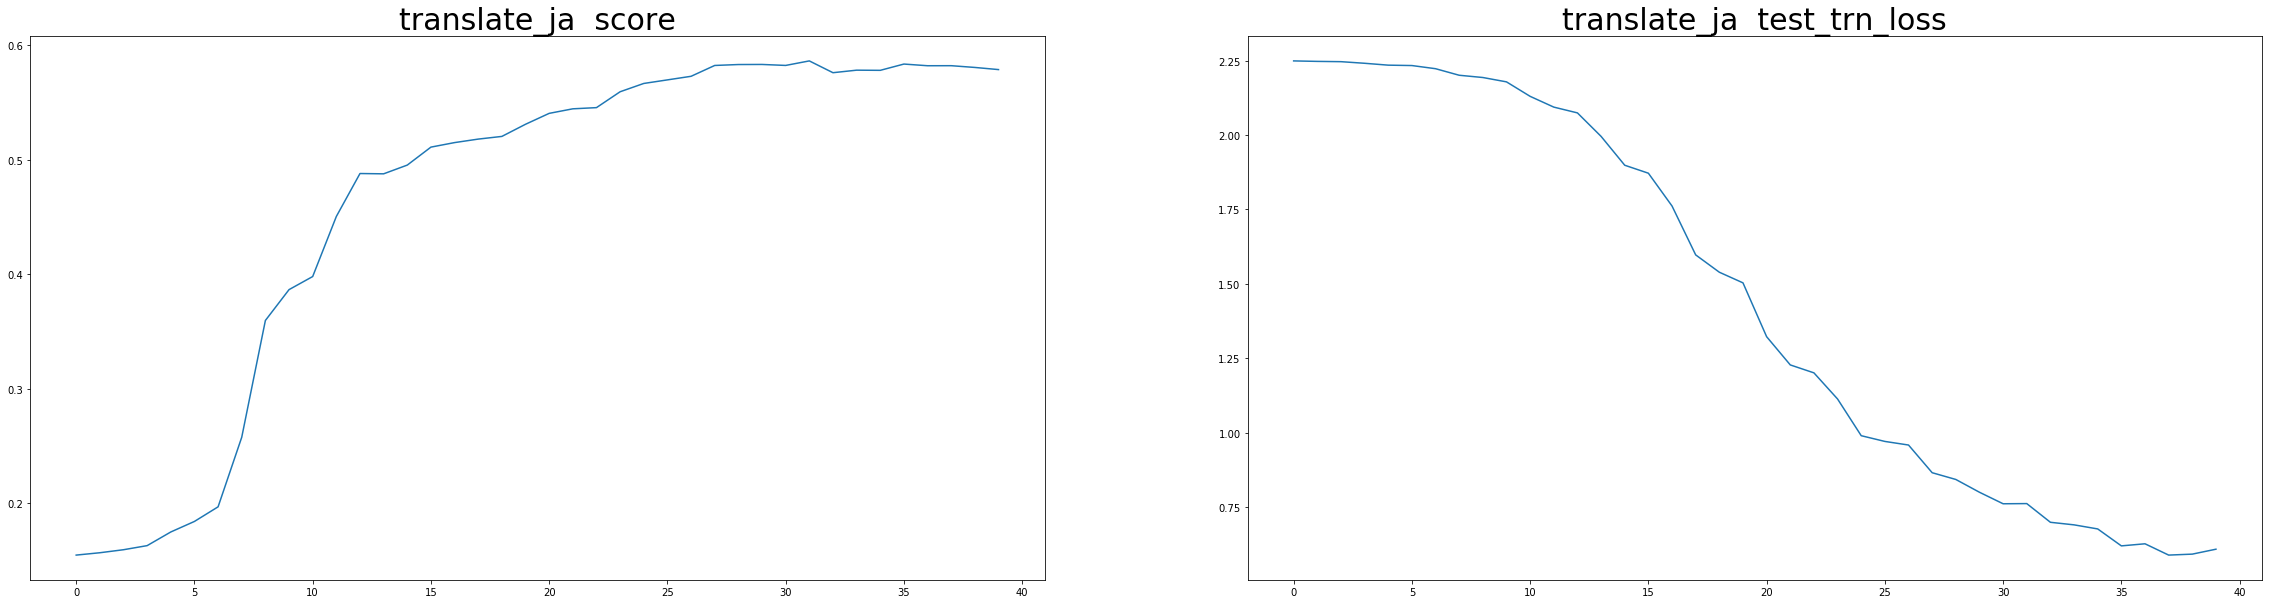

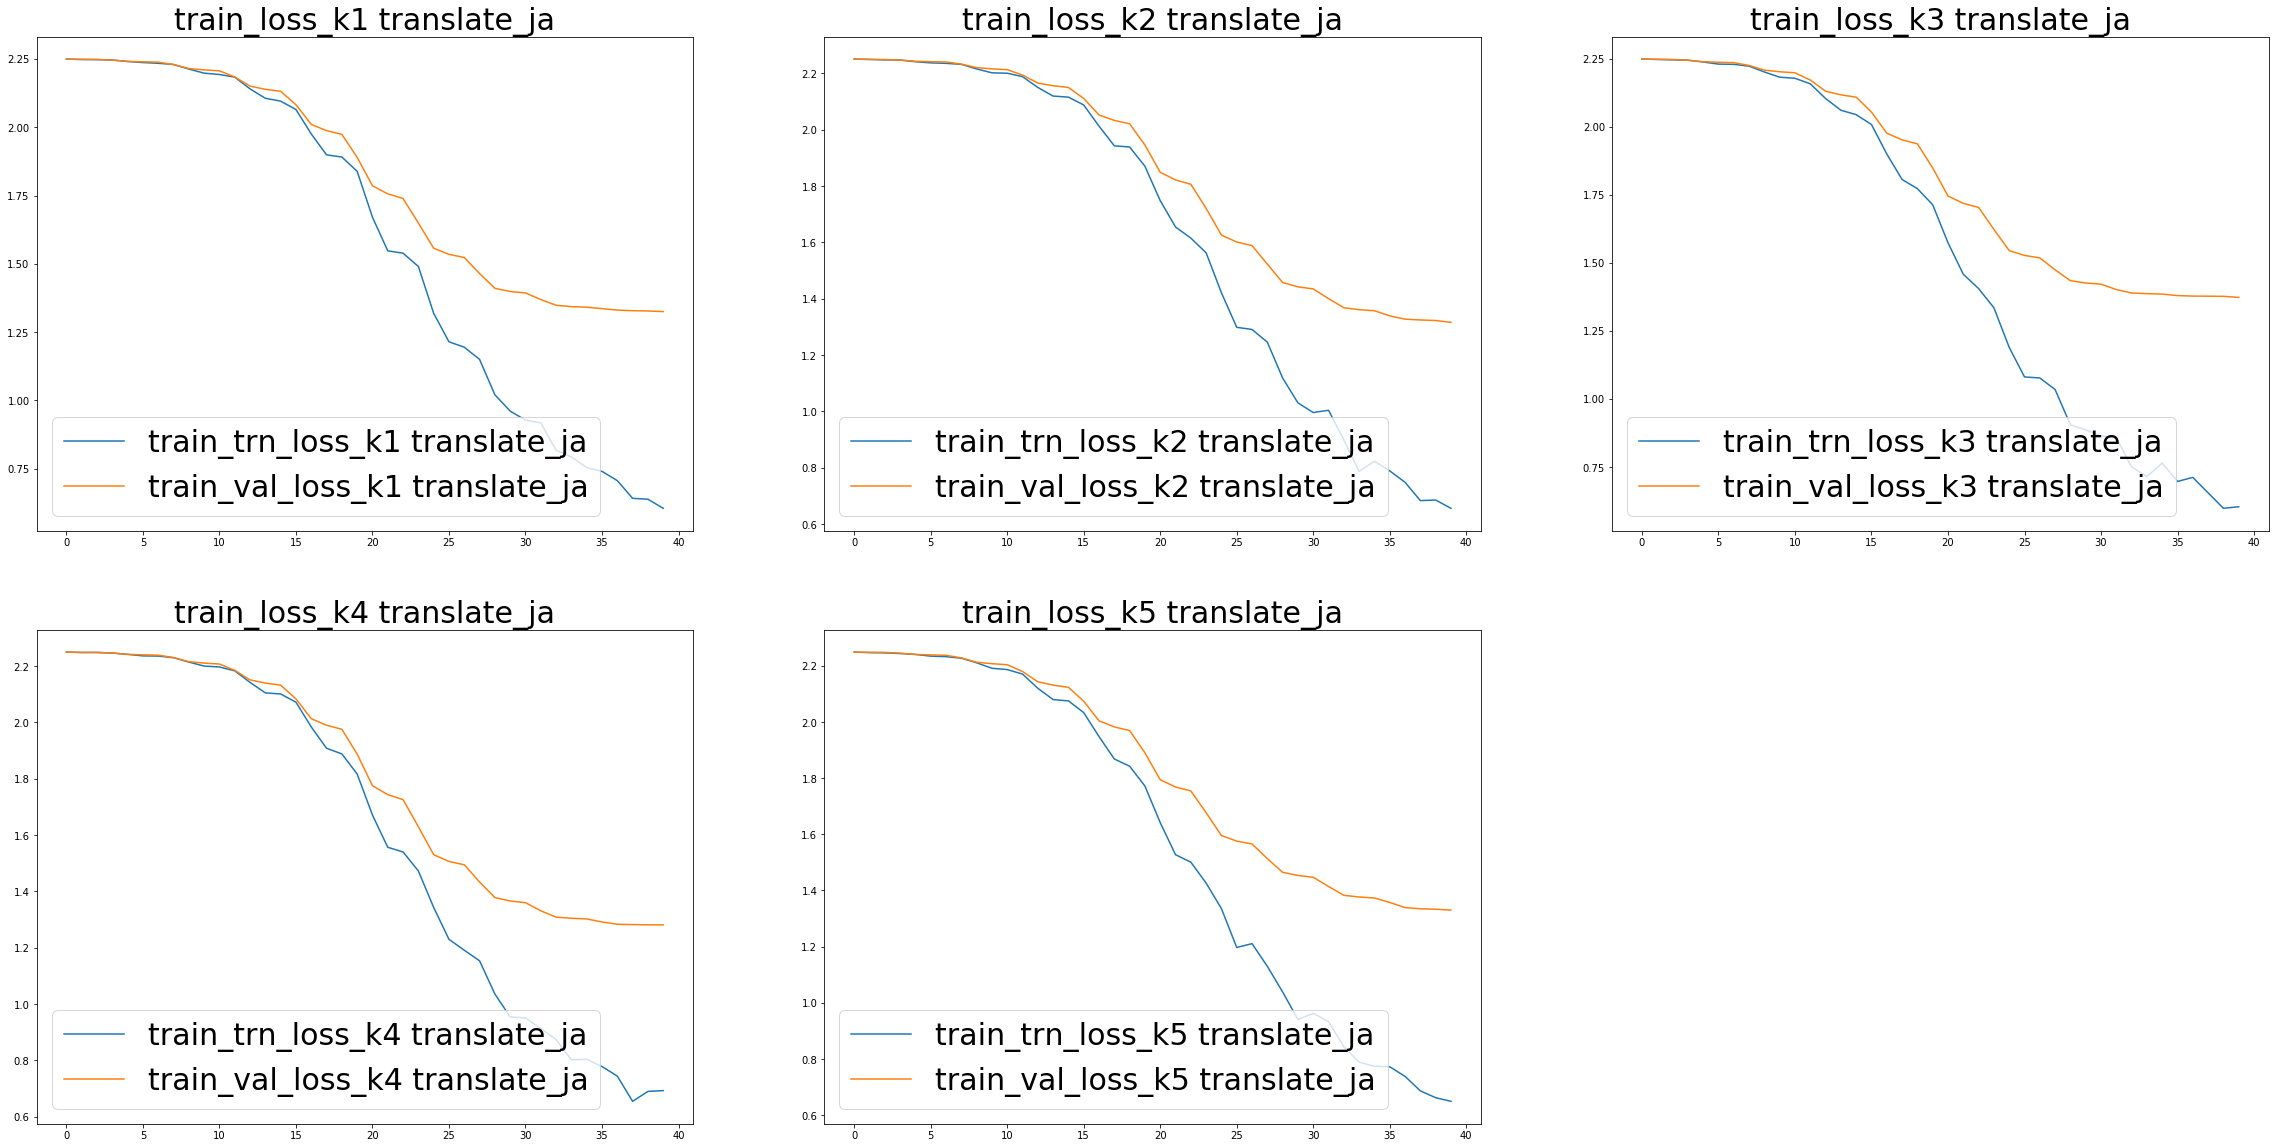

In [16]:
for key, result_df in result_dic.items():
    plt.figure(figsize=(40,10))
    plt.subplot(1,2,1)
    plt.plot(result_df['score'])
    plt.title(f'{key}  score', fontsize=30)
    plt.subplot(1,2,2)
    plt.plot(result_df['test_trn_loss'])
    plt.title(f'{key}  test_trn_loss', fontsize=30)
    
    plt.figure(figsize=(40,20))
    for i in range(1,6):
        plt.subplot(2,3,i)
        plt.plot(result_df[f'train_trn_loss_k{i}'], label=f'train_trn_loss_k{i} {key}')      
        plt.plot(result_df[f'train_val_loss_k{i}'], label=f'train_val_loss_k{i} {key}')      
        plt.legend(fontsize=30)
        plt.title(f'train_loss_k{i} {key}', fontsize=30)
        
    plt.show()

In [20]:
mlp_pred_cols = [f'p_{mm+1}_{e}' for e in range(40) for mm in range(4)]

In [21]:
off_df2 = pd.concat([
    off_df[mlp_pred_cols].rename(columns={col:f'{col}_{lang}' for col in mlp_pred_cols})
 for lang, off_df in off_df_dic.items()
], axis=1)

test_df2 =  pd.concat([
    t_df[mlp_pred_cols].rename(columns={col:f'{col}_{lang}' for col in mlp_pred_cols})
 for lang, t_df in test_df_dic.items()
], axis=1)

In [22]:
mlp_feature2 = [f'{col}_{lang}' for col in mlp_pred_cols for lang in test_df_dic.keys()]
test_df2 = pd.concat([test_df_dic['description']['text_id'], test_df2], axis=1)
off_df2 = pd.concat([off_df_dic['description'][['text_id', 'jobflag']], off_df2], axis=1)

In [23]:
off_df_mlp2, test_df_mlp2, result_data = make_step2_off(off_df2, test_df2, mlp_feature2)

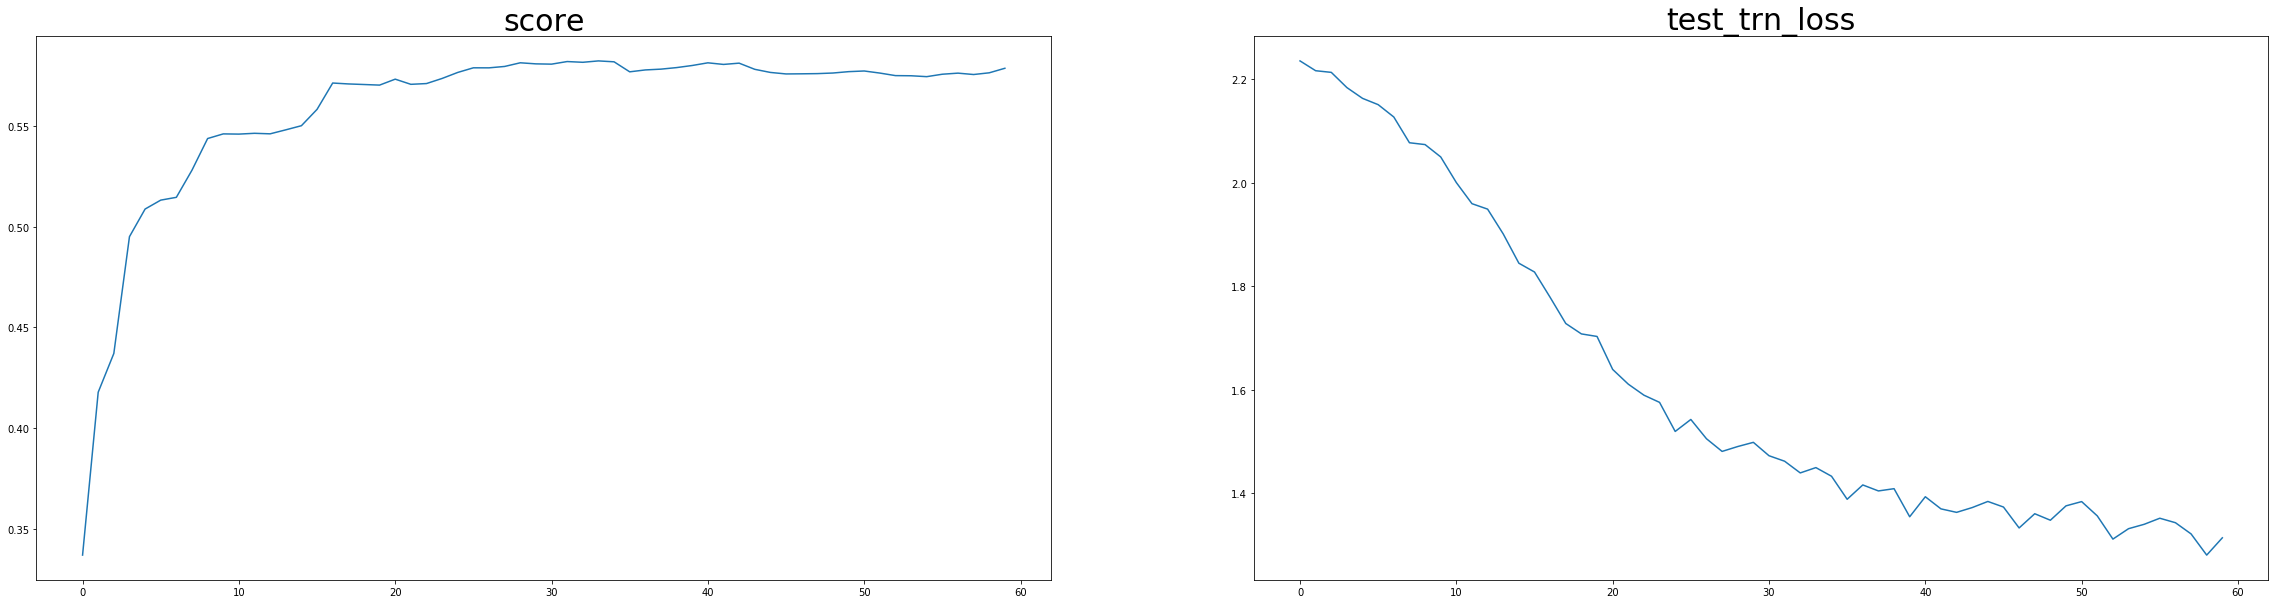

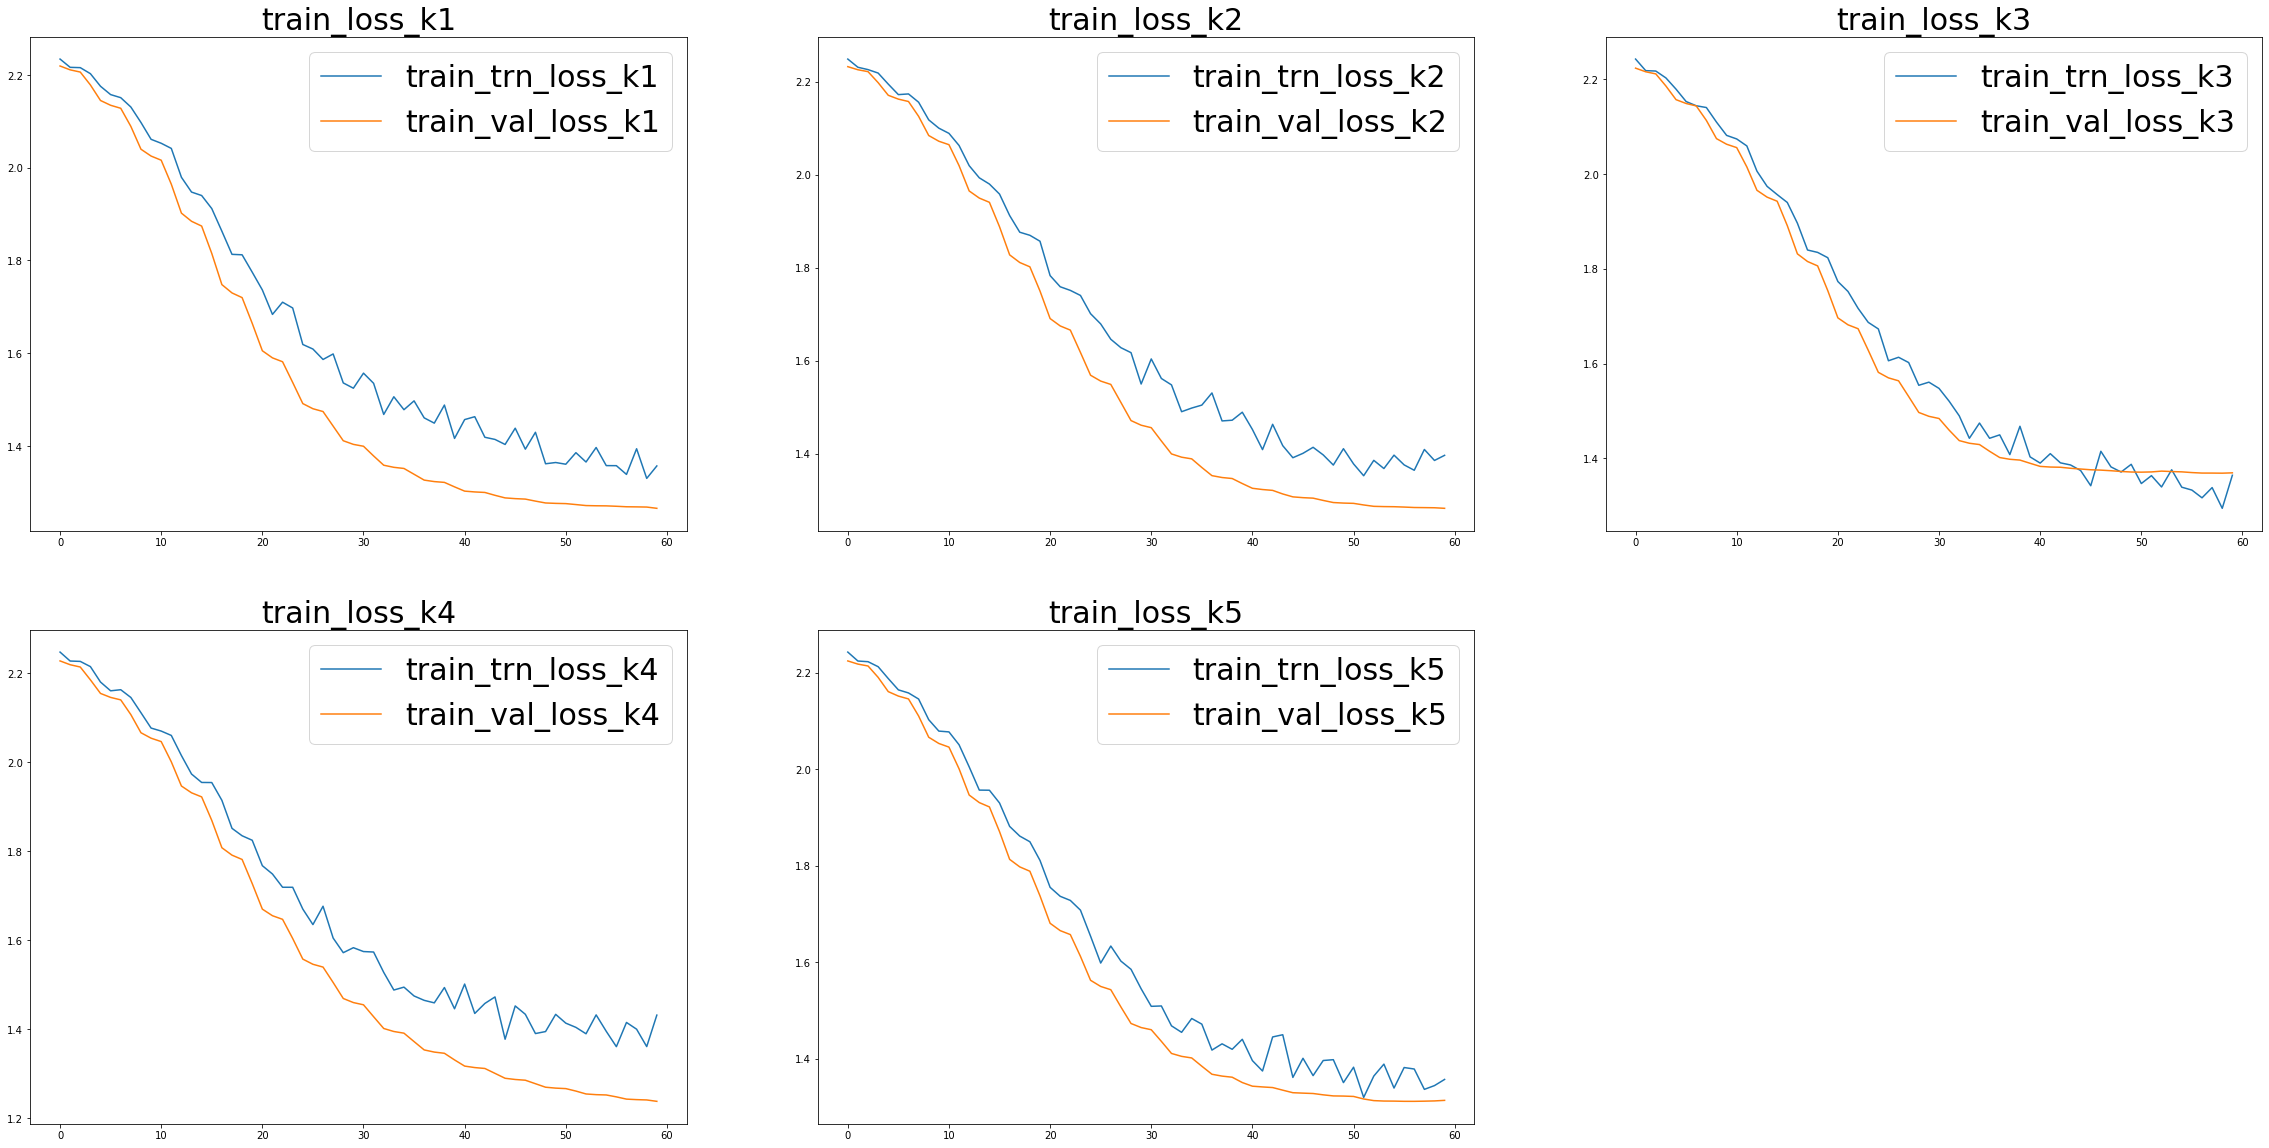

In [25]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,1)
plt.plot(result_data['score'])
plt.title(f'score', fontsize=30)
plt.subplot(1,2,2)
plt.plot(result_data['test_trn_loss'])
plt.title(f'test_trn_loss', fontsize=30)
    
plt.figure(figsize=(40,20))
for i in range(1,6):
    plt.subplot(2,3,i)
    plt.plot(result_data[f'train_trn_loss_k{i}'], label=f'train_trn_loss_k{i}')      
    plt.plot(result_data[f'train_val_loss_k{i}'], label=f'train_val_loss_k{i}')      
    plt.legend(fontsize=30)
    plt.title(f'train_loss_k{i}', fontsize=30)        
plt.show()

In [26]:
result_data[result_data['score']>0.58]

,score,test_trn_loss,train_trn_loss_k1,train_val_loss_k1,train_trn_loss_k2,train_val_loss_k2,train_trn_loss_k3,train_val_loss_k3,train_trn_loss_k4,train_val_loss_k4,train_trn_loss_k5,train_val_loss_k5
28,0.581549,1.489856,1.536027,1.411366,1.617122,1.470957,1.554055,1.496696,1.572162,1.469307,1.585175,1.472903
29,0.581015,1.497974,1.524600,1.403532,1.549648,1.460998,1.560638,1.488533,1.583332,1.460145,1.544826,1.464488
30,0.580875,1.472100,1.557067,1.399498,1.603630,1.455673,1.547491,1.483933,1.574668,1.455138,1.508479,1.459986
31,0.582164,1.461465,1.535146,1.378582,1.561577,1.427031,1.520428,1.459360,1.573633,1.428372,1.509235,1.435891
32,0.581797,1.438839,1.468053,1.358609,1.547776,1.399200,1.489552,1.437253,1.527888,1.401945,1.468069,1.410819
33,0.582484,1.449132,1.506188,1.354061,1.490066,1.392170,1.442127,1.431665,1.488285,1.395202,1.454597,1.404802
34,0.582036,1.432396,1.478270,1.351608,1.497917,1.388572,1.474349,1.428920,1.494800,1.391439,1.483265,1.401505
39,0.580204,1.354067,1.416353,1.311935,1.488969,1.335448,1.402949,1.389398,1.446209,1.331406,1.440158,1.350549
40,0.581534,1.392767,1.456975,1.302740,1.451854,1.325245,1.389752,1.382810,1.501701,1.317539,1.395956,1.342989
41,0.580736,1.369320,1.463189,1.301001,1.408487,1.322573,1.409696,1.381431,1.435706,1.314206,1.374447,1.341455


In [27]:
test_df_mlp2.head()

,text_id,p_1_0_description,p_2_0_description,p_3_0_description,p_4_0_description,p_1_1_description,p_2_1_description,p_3_1_description,p_4_1_description,p_1_2_description,...,p_1_58,p_2_58,p_3_58,p_4_58,p_58,p_1_59,p_2_59,p_3_59,p_4_59,p_59
0,2931,0.233067,0.250014,0.253957,0.262962,0.233235,0.250163,0.253837,0.262765,0.233788,...,0.144356,0.795828,0.048122,0.011694,2,0.139515,0.805460,0.044179,0.010845,2
1,2932,0.233119,0.249223,0.253629,0.264030,0.233306,0.249320,0.253523,0.263851,0.233906,...,0.006113,0.020478,0.868439,0.104971,3,0.005908,0.020618,0.870953,0.102521,3
2,2933,0.232800,0.249851,0.253561,0.263788,0.233018,0.250001,0.253454,0.263527,0.233797,...,0.110596,0.771725,0.102401,0.015278,2,0.106747,0.784123,0.094951,0.014179,2
3,2934,0.233681,0.249937,0.253508,0.262874,0.234004,0.250048,0.253286,0.262662,0.235275,...,0.891329,0.100295,0.002498,0.005878,1,0.892091,0.100103,0.002280,0.005526,1
4,2935,0.232613,0.249481,0.254000,0.263907,0.232814,0.249475,0.253896,0.263816,0.233433,...,0.012818,0.009066,0.320021,0.658094,4,0.012648,0.008923,0.315701,0.662728,4


In [49]:
preds = np.zeros((len(off_df_mlp2), 4))
for i in range(25, 40):
    preds += off_df_mlp2[[f'p_{label+1}_{i}'  for label in range(4)]].values
for i in range(4):
    off_df_mlp2[f'final_preds_{i+1}'] = preds[:,i]
off_df_mlp2['final_preds'] = 1+np.argmax(preds, axis=1)
off_df_mlp2[['text_id', 'jobflag' ,'final_preds', 'final_preds_1', 'final_preds_2', 'final_preds_3', 'final_preds_4']].head()

,text_id,jobflag,final_preds,final_preds_1,final_preds_2,final_preds_3,final_preds_4
0,0,2.0,3,0.623598,0.833486,10.930948,2.611968
1,1,3.0,3,0.713477,1.243521,9.184126,3.858875
2,2,4.0,4,1.167065,0.841164,2.918121,10.073650
3,3,1.0,1,5.381074,3.693153,2.766585,3.159188
4,4,4.0,3,0.883962,0.870414,7.537465,5.708159


In [50]:
metrics.f1_score(off_df_mlp2.jobflag, off_df_mlp2.final_preds, average='macro')

0.5824167842795475

In [ ]:
preds = np.zeros((len(test_df_mlp2), 4))
for i in range(10, 25):
    preds += test_df_mlp2[[f'p_{label+1}_{i}'  for label in range(4)]].values
test_df_mlp2['final_preds'] = 1+np.argmax(preds, axis=1)
test_df_mlp2[['text_id', 'final_preds']].head()

In [ ]:
#test_df_mlp2[['text_id', 'final_preds']].to_csv('/Users/abcdm/Downloads/sub_18.csv', index=False, header=False)

In [ ]:
#test_df_mlp2.final_preds.value_counts()

In [ ]:
data = pd.merge(
    pd.read_csv('/Users/abcdm/Downloads/sub_17.csv', header=None),
    pd.read_csv('/Users/abcdm/Downloads/sub_18.csv', header=None),
    on=[0]
)

pd.concat([
    pd.get_dummies(data['1_x']).rename(
        columns={i+1:f'{i+1}_17' for i in range(4)}
    ),
    pd.get_dummies(data['1_y']).rename(
        columns={i+1:f'{i+1}_18' for i in range(4)}
    )
], axis=1).corr().loc[
    [f'{i+1}_17' for i in range(4)],[f'{i+1}_18' for i in range(4)]
]

In [ ]:
sns.jointplot(data=data[data['1_x']!=data['1_y']], x='1_x', y='1_y')